## Análise de estilo dinâmica utilizando Filtro de Kalman

Análise dinâmica de estilo baseada em retornos (DSA, do inglês Dynamic Style Analisys) é uma técnica investigativa que busca identificar a estratégia de um fundo por meio da estimação das frações do portifólio investido em determinados ativos durante um certo intervalo de tempo.

Este notebook demonstra uma forma de se aplicar o filtro de Kalman para estimação dos pesos dos ativos em um portfolio sintético

### Importação de bibiliotecas e definições padrão

In [171]:
import pandas as pd
import numpy as np
import seaborn as sns
import string

from filterpy.common import Saver
from filterpy.kalman import rts_smoother
from filterpy.kalman import KalmanFilter

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 10)

### Ativos 
São definidos 3 ativos (a,b,c) com retornos $r$ aleatóriamente distribuidos da seguinte forma:

$$
\begin{align}
\begin{pmatrix}
r_a\\
r_b\\
r_c
\end{pmatrix}
& \sim 
\mathcal{N}
\begin{pmatrix}
\mu , 
\Sigma
\end{pmatrix};
\end{align}
\Sigma = \sigma \cdot \sigma^T \cdot \rho
$$
com :
$$
\begin{align}
\mu = 
\begin{pmatrix}
0\\
0\\
0
\end{pmatrix};
\sigma = 
\begin{pmatrix}
0.4\\
0.15\\
0.05
\end{pmatrix} * \dfrac{1}{\sqrt{252}};
\rho = 
\begin{pmatrix}
1 & 0.7 & 0\\
0.7 & 1 & 0 \\
0 & 0 & 1
\end{pmatrix}
\end{align}
$$
<br>
a amostra dos retornos de cada ativo são 1000 dias comerciais desde 01/01/2000

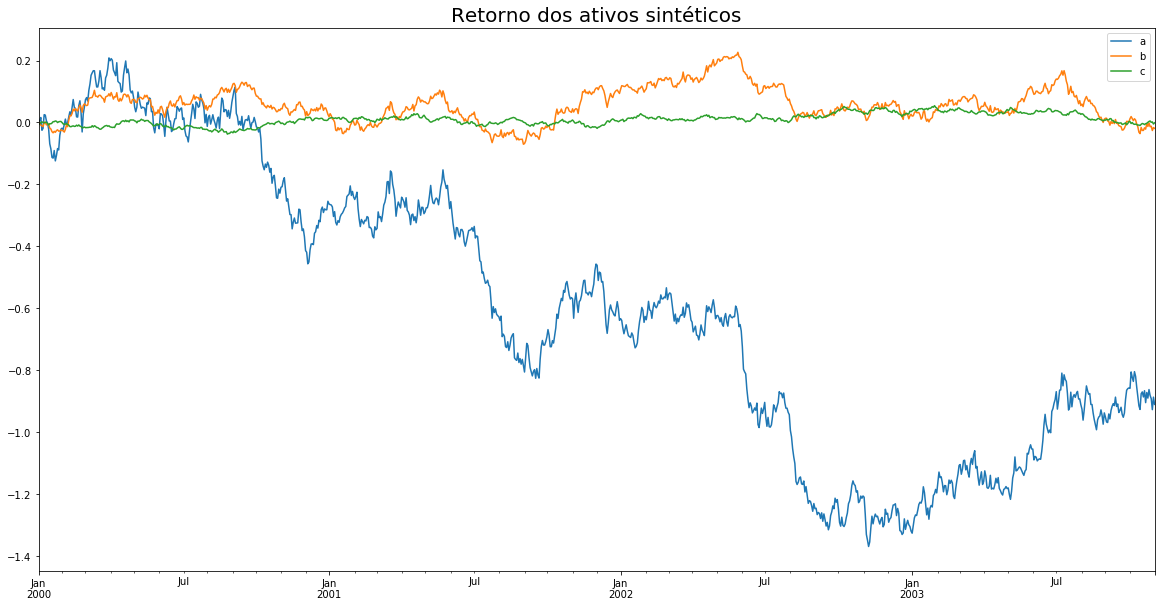

In [41]:
mean = [0, 0, 0]
stds = np.array([0.4, 0.15, 0.05]) / 252 ** 0.5
corr = np.eye(3) 
corr[1,0] = corr[0,1]  = 0.7
cov = np.multiply(np.outer(stds,stds), corr)
returns = np.random.multivariate_normal(mean, cov, 1000)
stock = pd.DataFrame(returns, columns=list(string.ascii_lowercase[:len(mean)]), index=pd.date_range('2000-01-01', freq='B', periods=returns.shape[0]))
stock.cumsum().plot(figsize=(20,10))
plt.title("Retorno dos ativos sintéticos", fontsize='20');

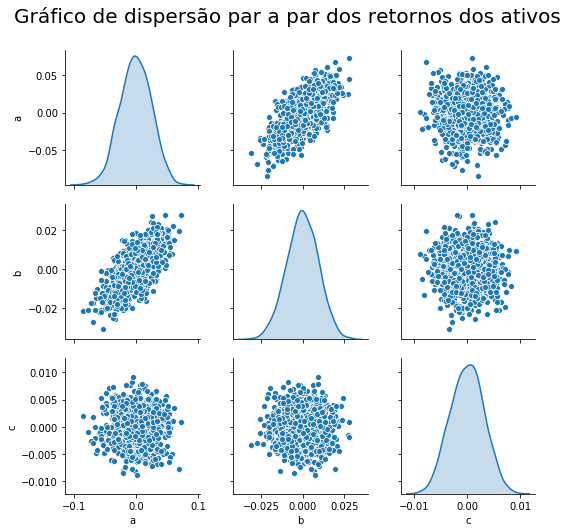

In [49]:
g = sns.pairplot(stock, diag_kind='kde')
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Gráfico de dispersão par a par dos retornos dos ativos", fontsize='20');

## Portfolio
Alocação inicial dada por $\omega_a = 0.5; \ \omega_b = 0.2; \ \omega_c = 0.1$ com probabilidades de realocação P(N=p_x) que seguem uma distribuição binomial sendo: $ \ p_a = 0.02; \ p_b = 0.03; \ p_c=0.01$ e amplitudes de realocação normalmente distribuidos com $\mathcal{N} \sim (0.01, 0.1)$
<br>
em t=600 (22/04/2002) a alocação no ativo a vai a zero e a alocação no ativo c é mantida em 0.25

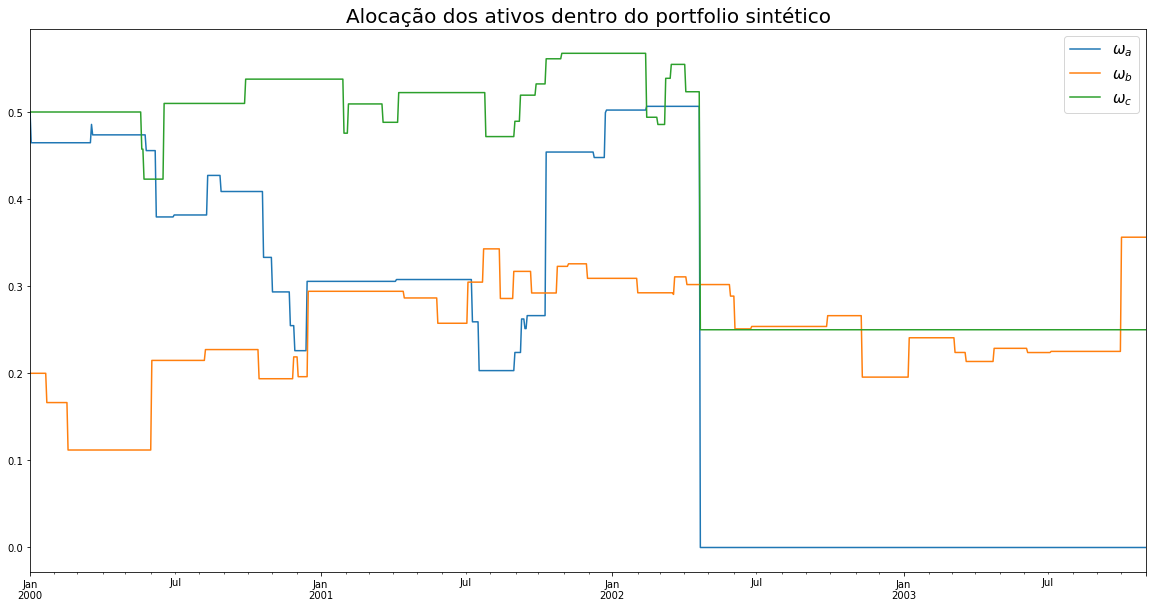

In [157]:
p1 = pd.DataFrame(index=stock.index, columns=stock.columns)
p1[['a','b','c']] = [0.5, 0.2, 0.5]

p1['a'] += (np.random.normal(0.01, 0.05, 1000) *  np.random.binomial(1,0.02,1000)).cumsum()
p1['b'] += (np.random.normal(0.01, 0.05, 1000) *  np.random.binomial(1,0.03,1000)).cumsum()
p1['c'] += (np.random.normal(0.01, 0.05, 1000) *  np.random.binomial(1,0.05,1000)).cumsum()

p1.loc[600:, 'a'] = 0
p1.loc[600:, 'c'] = 0.25

p1.plot(figsize=(20,10), legend=False)
plt.title("Alocação dos ativos dentro do portfolio sintético", fontsize='20');
plt.legend(['$\omega_a$','$\omega_b$','$\omega_c$'], fontsize='15');

# Filtro de Kalman
para modelagem foi usada a biblioteca [filterpy](https://filterpy.readthedocs.io/en/latest/) as matrizes foramm definidas da seguinte forma: <br>

Matriz de estados | Matriz de medidas | Matriz de Transição | Matriz ruido do processo | Matriz ruído das medidas  
---|---|---|---|---|
$ X = \begin{bmatrix} \hat{\omega_a} \\ \hat{\omega_b} \\ \hat{\omega_c} \end{bmatrix}; $ | $ Z = \begin{bmatrix} r_p \\ \omega_a \\ \omega_b \\ \omega_c \end{bmatrix}; $ |  $ F = I_3 ; $ |  $ Q = I_3 * 0.0005; $ | $ R = I_4 * 1e-10; $ 

A matriz H converte a matriz de estados X no vetor de medidas Z, afim de calcular-se o erro de projecão e consequente ganho Kalman: 
$ H = \begin{bmatrix} r_a & r_b & r_c  \\ \zeta_a & 0 & 0 \\ 0 & \zeta_b & 0 \\ 0 & 0 & \zeta_c \end{bmatrix} $ <br>

Havendo alguma informação disponível a respeito do peso de determinado ativo no porfolio no tempo t, nesta iteração, o elemento $\zeta$ correspondente da matriz H é setado como 1

ao final é aplicado o algoritimo rts smooth

####  Caso base, nenhuma informação sobre o peso dos ativos

$ H = \begin{bmatrix} r_a & r_b & r_c  \\ 0 & 0 & 0 \\ 0 & 0 & 0 \\ 0 & 0 & 0 \end{bmatrix} $ <br>

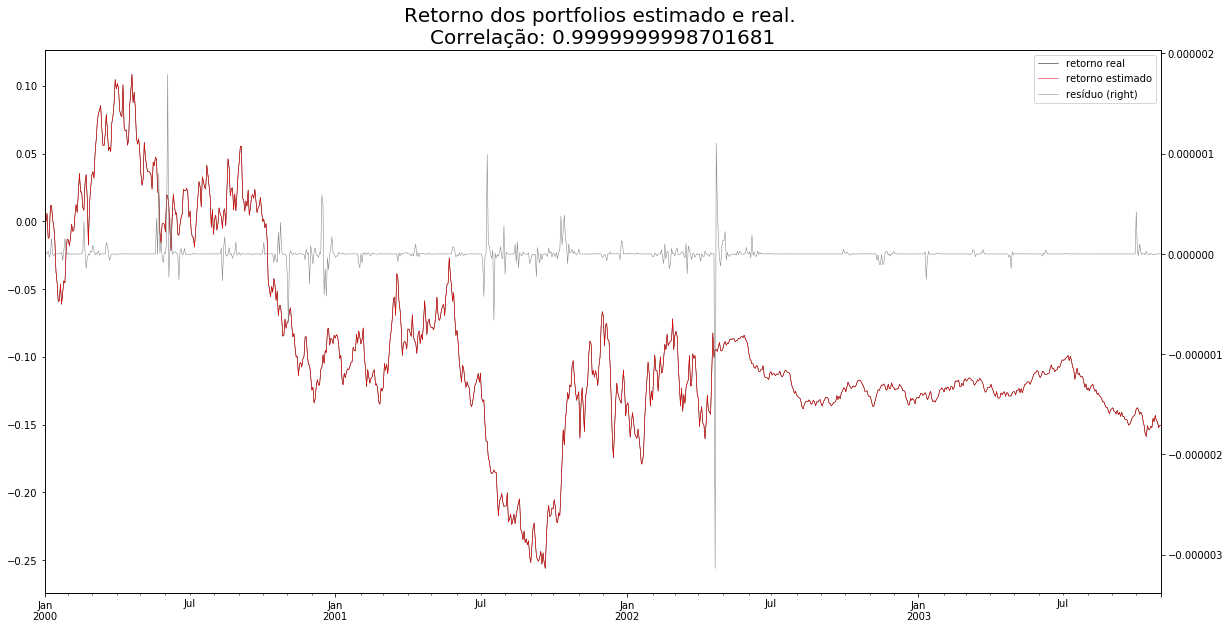

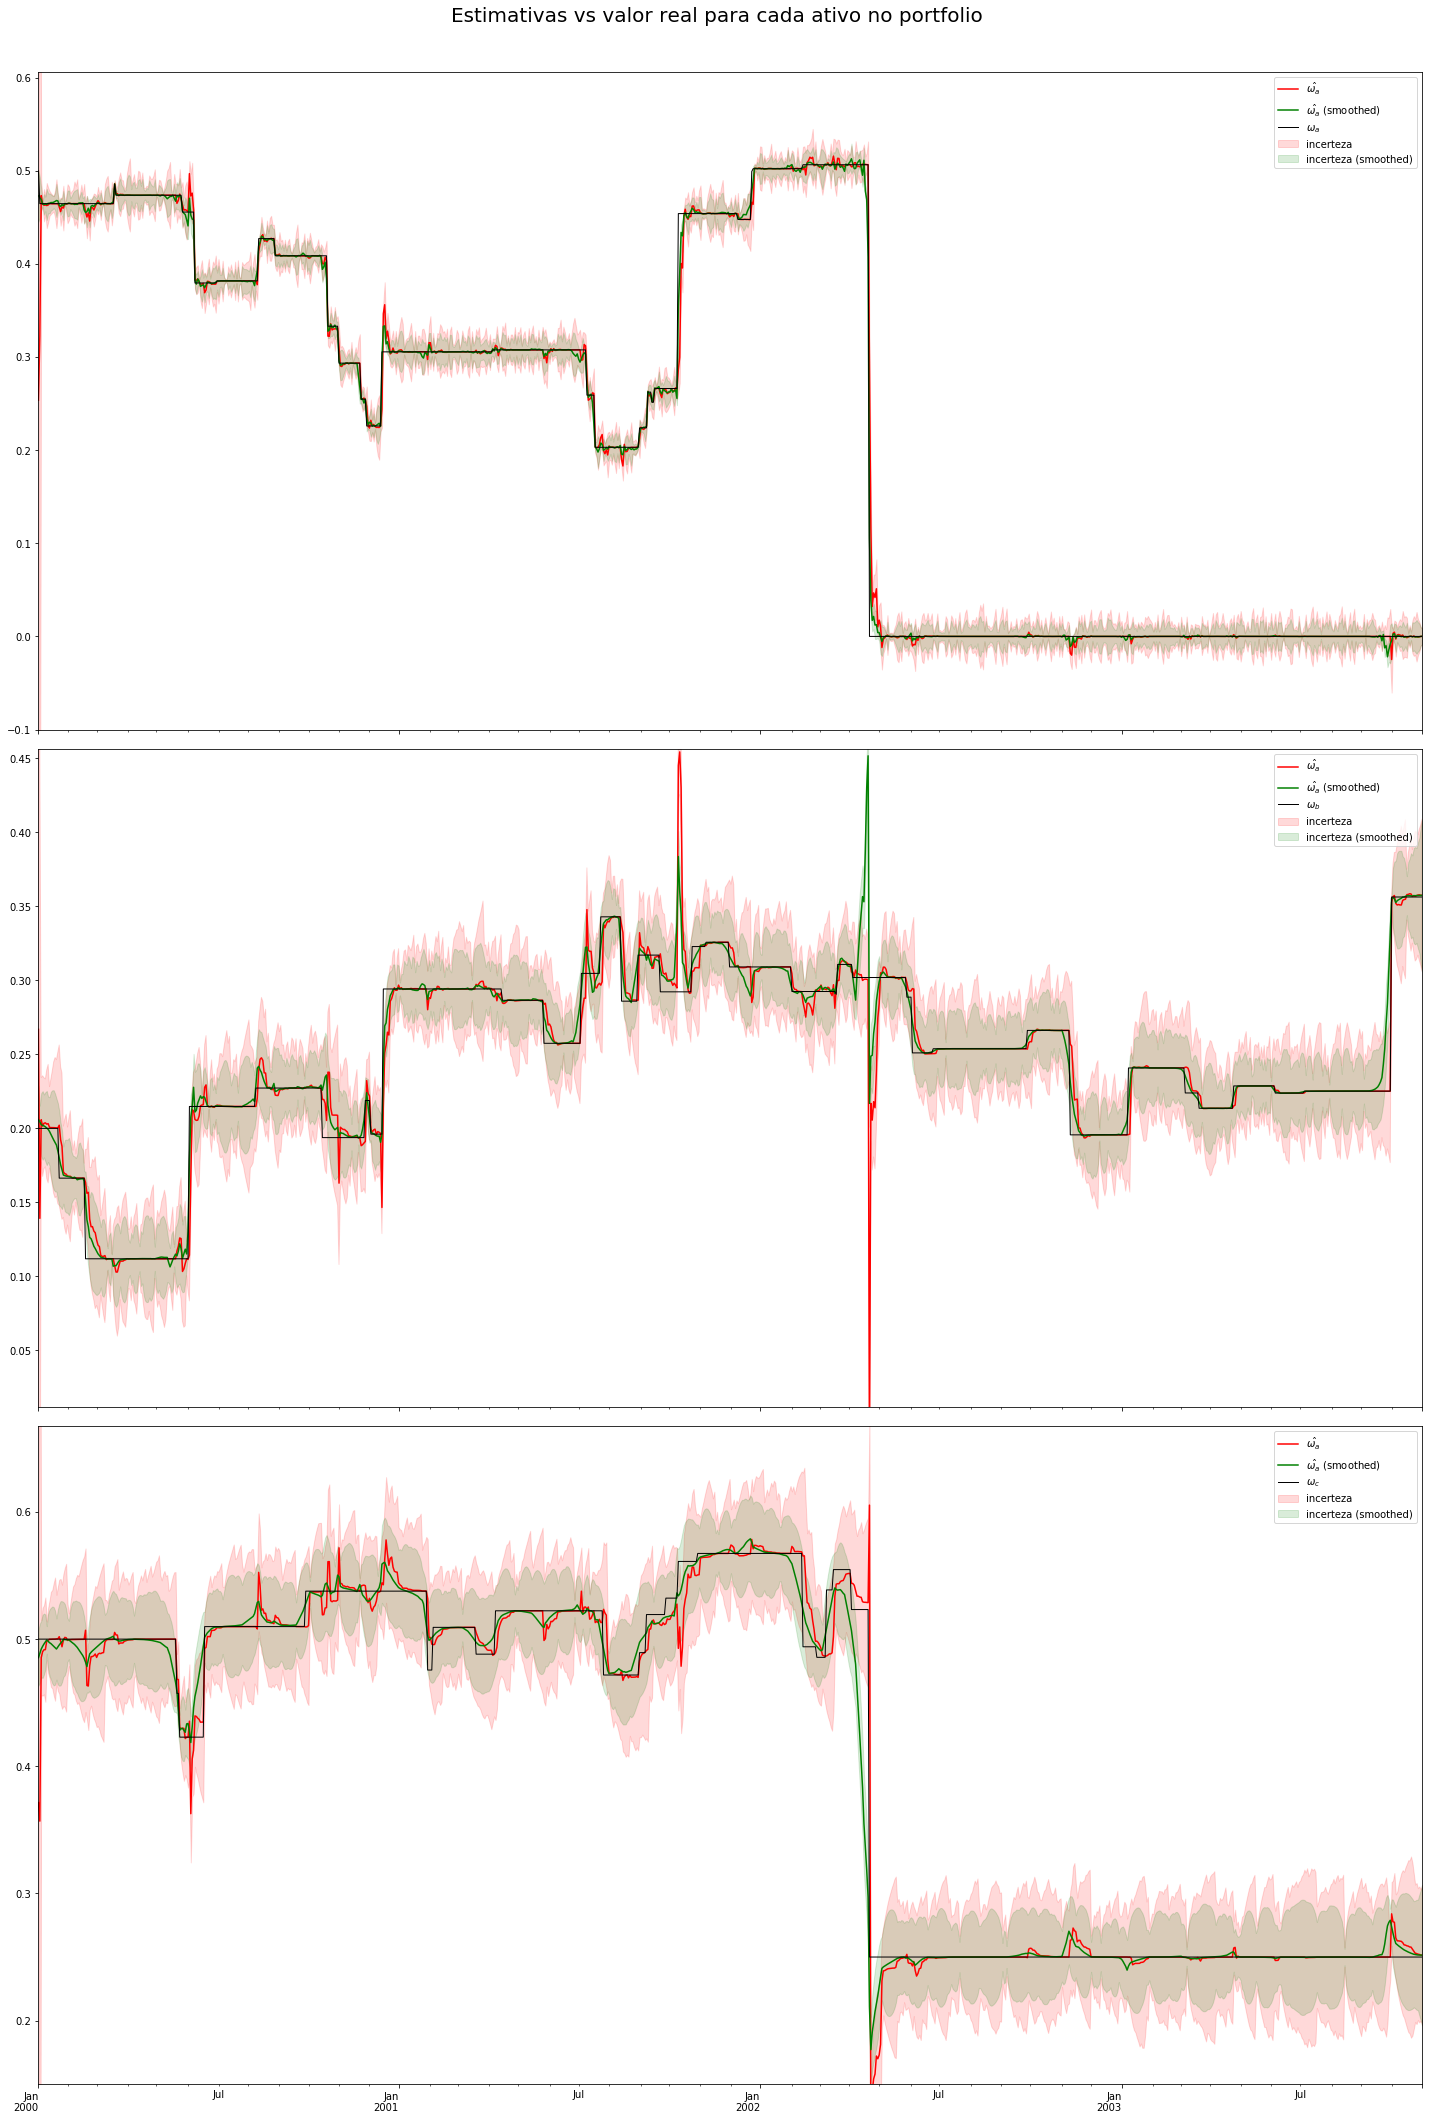

In [429]:
kf = KalmanFilter(3,4)

#State Transition Function F
kf.F = np.eye(3) * 1

#Process Noise Q
kf.Q *= 0.0005

#Initial Guess
kf.x = np.array([0.3, 0.3, 0.3])

#Measurement Noise R
kf.R *= 1e-10

#faz o loop para cada data
s = Saver(kf)
for i,dt in enumerate(stock.index):
    #Measurement Function H
    kf.H = np.zeros((4,3))
    kf.H[0] = stock.loc[dt].values.reshape(1,3)
    kf.predict() 
    kf.update(np.hstack([p1_return.loc[dt], p1.loc[dt]]))
    s.save()  
s.to_array()

## Calcula as matrizes smoothed
sx, sP, sK, spP = rts_smoother(s.x, s.P, s.F, s.Q)

retorno_estimado = pd.DataFrame(s.x, index=p1.index, columns=p1.columns).mul(stock).sum(axis=1)
#plota o retorno do portfolio estimado e os erros

ax = p1_return.cumsum().plot(figsize=(20,10), label="retorno real", color='black', lw=0.5, legend=True)
retorno_estimado.cumsum().plot(ax=ax, legend=True, color='red', label='retorno estimado', lw=0.5)
(p1_return - retorno_estimado).plot(secondary_y=True, color='gray', lw=0.5, label='resíduo', legend=True)
plt.title(f"Retorno dos portfolios estimado e real. \nCorrelação: {retorno_estimado.corr(p1_return)}", fontsize='20')

#Plota o grafico comparativo pra cada ativo
ax = pd.DataFrame(s.x, index=p1.index, columns=[r'$\hat{\omega_a}$',r'$\hat{\omega_a}$',r'$\hat{\omega_a}$' ]).plot(figsize=(20,30), color='red', linestyle='-', lw=1.5, subplots=True)
ax = pd.DataFrame(sx, index=p1.index, columns=[r'$\hat{\omega_a}$ (smoothed)',r'$\hat{\omega_a}$ (smoothed)',r'$\hat{\omega_a}$ (smoothed)' ]).plot(color='green', linestyle='-', lw=1.5, ax=ax, subplots=True)
ax = p1.rename(columns={k:"$\omega_"+k+"$" for k in p1}).plot(color='black', linestyle='-', lw=1, ax=ax, subplots=True)
[i.legend(fontsize='15') for i in ax]
for i,_ in enumerate(p1):
    ax[i].fill_between(p1.index.to_native_types(), (s.x[:,i] - np.sqrt(s.P[:,i,i])).astype(float), (s.x[:,i] + np.sqrt(s.P[:,i,i])).astype(float), alpha=0.15, color='red', label="incerteza")    
for i,_ in enumerate(p1):
    ax[i].fill_between(p1.index.to_native_types(), (sx[:,i] - np.sqrt(sP[:,i,i])).astype(float), (sx[:,i] + np.sqrt(sP[:,i,i])).astype(float), alpha=0.15, color='green', label='incerteza (smoothed)')
    ax[i].set_ylim(p1.iloc[:,i].min() - 0.1,p1.iloc[:,i].max()+ 0.1)
    ax[i].legend()

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.gcf().suptitle("Estimativas vs valor real para cada ativo no portfolio", fontsize="20");



####  Caso alternativo 1, informação sobre os peso dos ativos em t = 600

$ H = \begin{bmatrix} r_a & r_b & r_c  \\ 0 & 0 & 0 \\ 0 & 0 & 0 \\ 0 & 0 & 0 \end{bmatrix};  $ $ H_{t=600} = \begin{bmatrix} r_a & r_b & r_c  \\ 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 1 & 0 \end{bmatrix} $ <br>

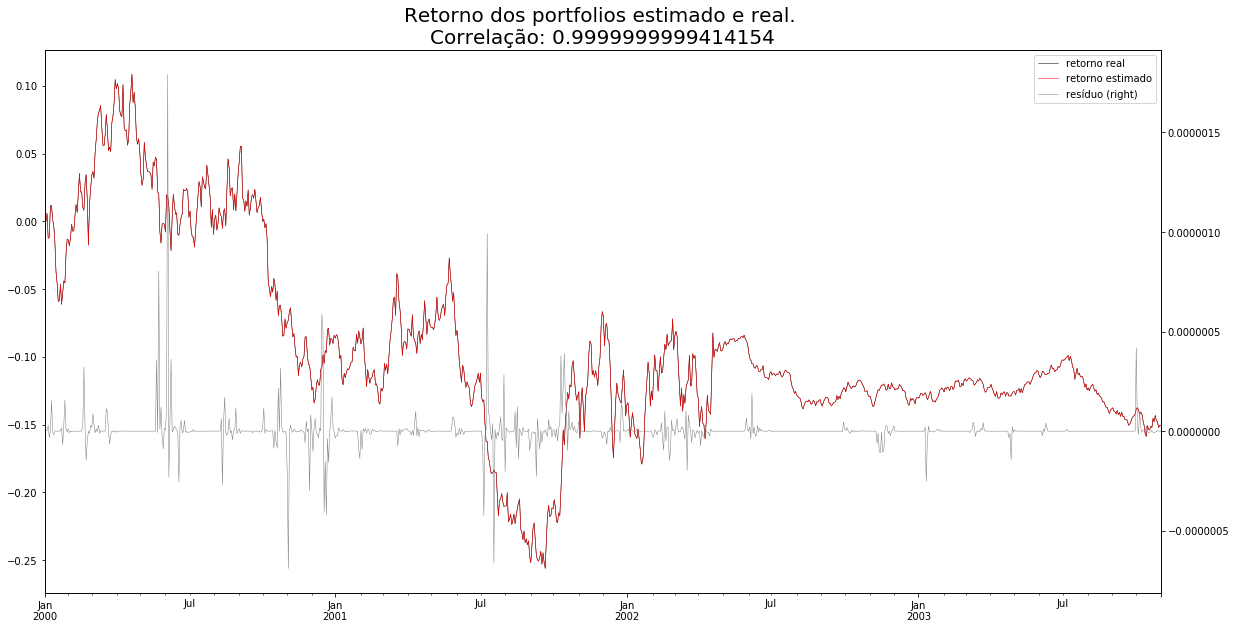

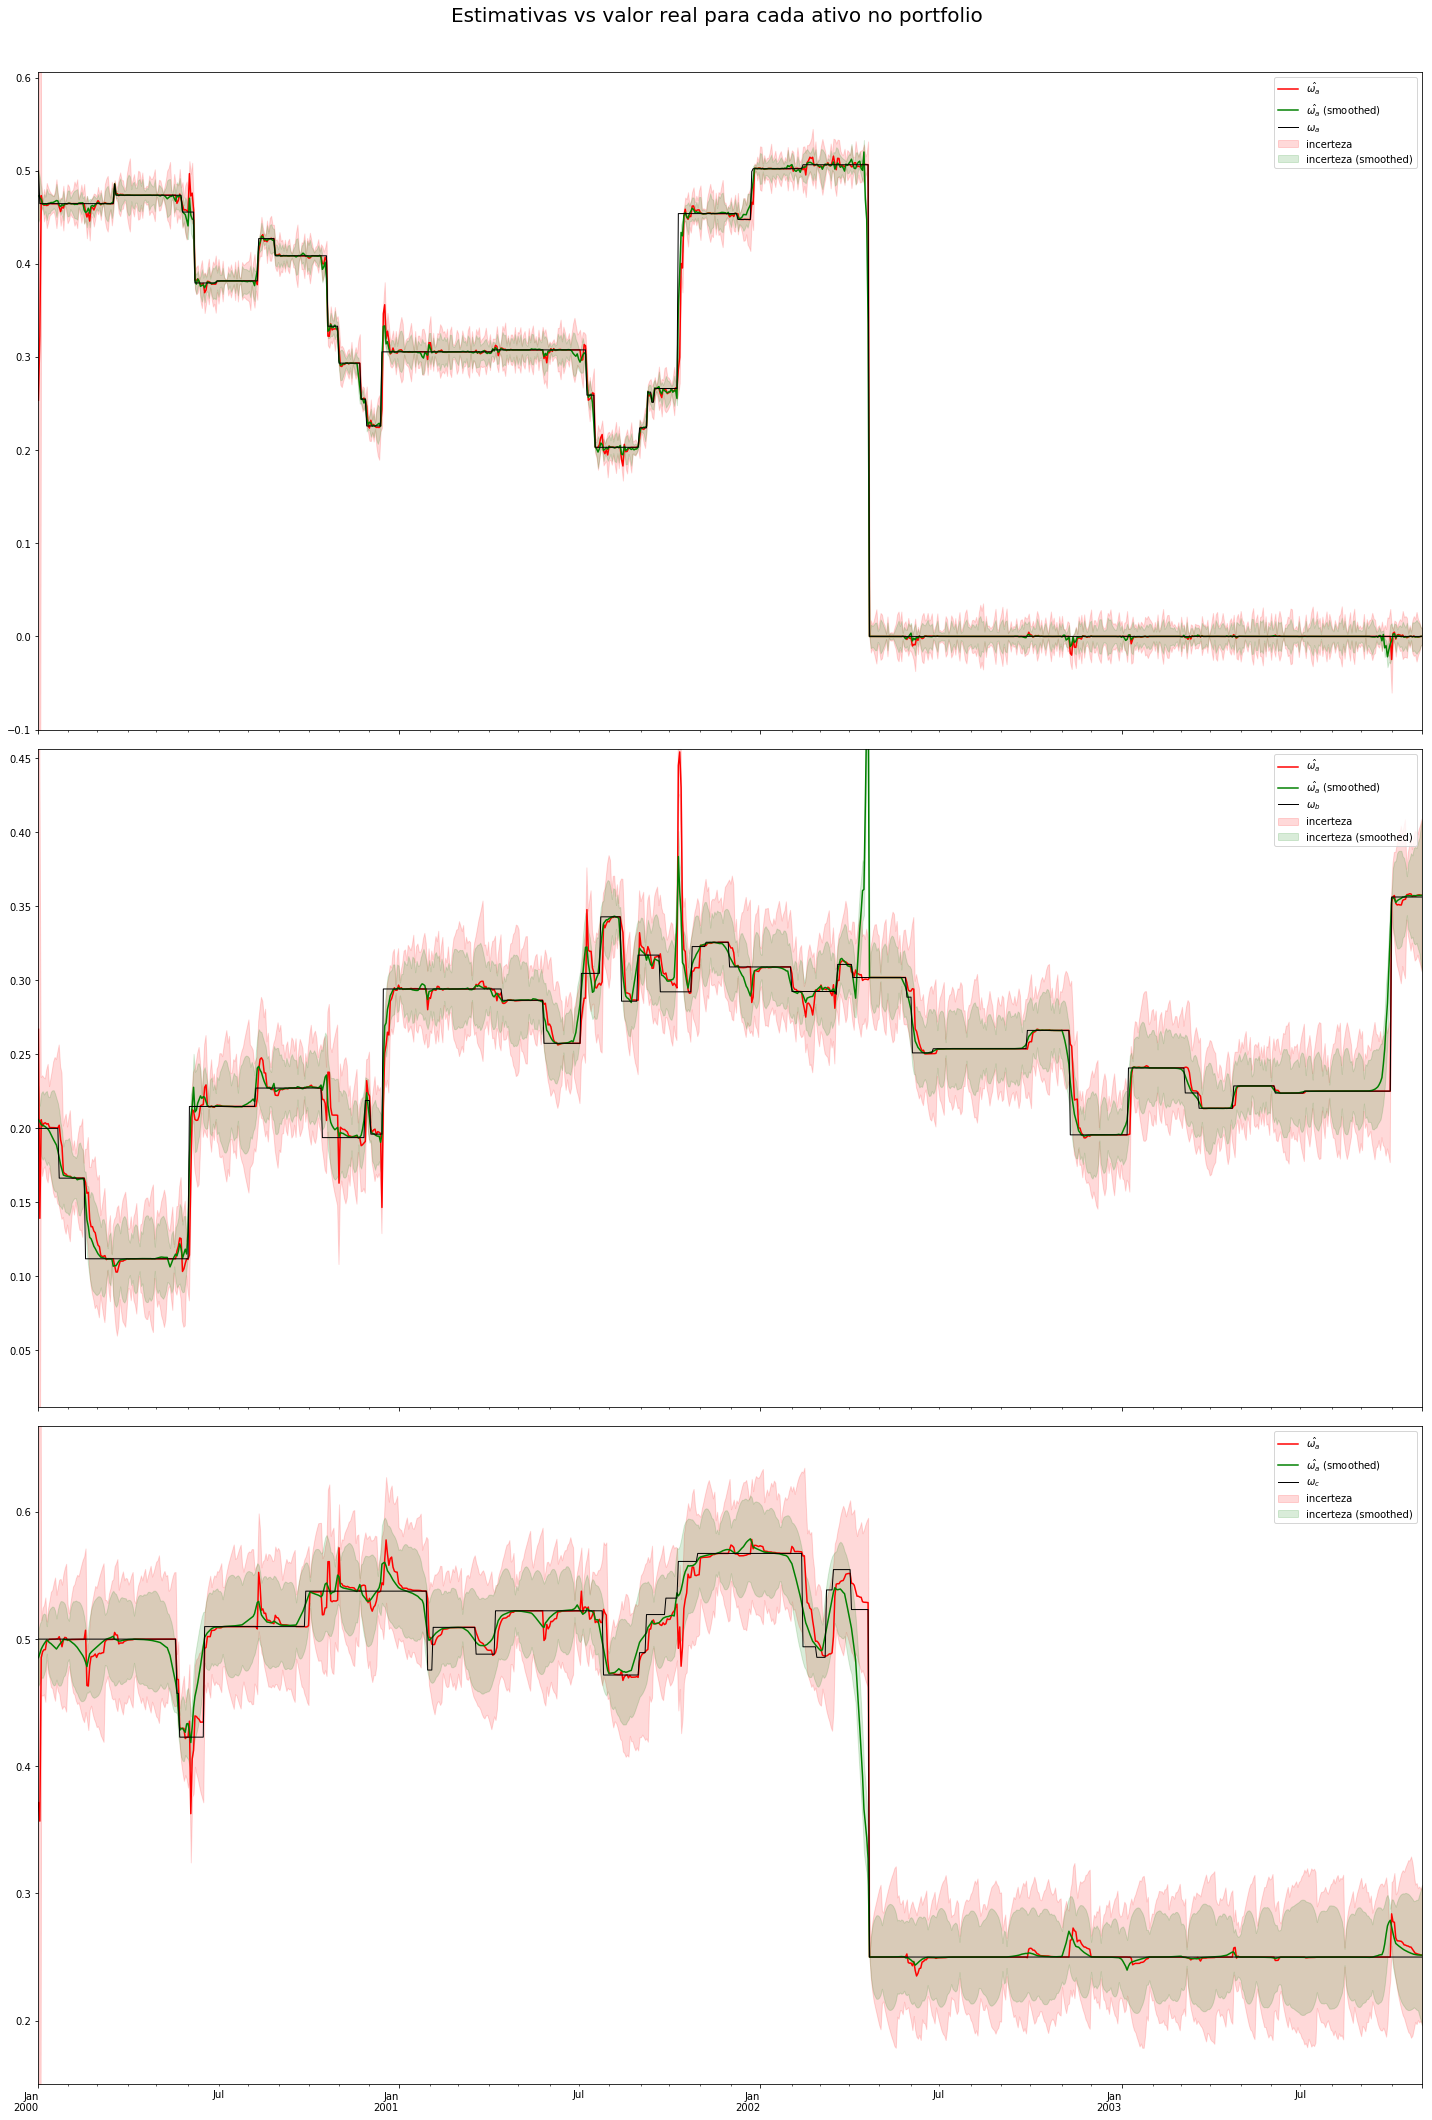

In [431]:
kf = KalmanFilter(3,4)

#State Transition Function F
kf.F = np.eye(3) * 1

#Process Noise Q
kf.Q *= 0.0005

#Initial Guess
kf.x = np.array([0.3, 0.3, 0.3])

#Measurement Noise R
kf.R *= 1e-10

#faz o loop para cada data
s = Saver(kf)
for i,dt in enumerate(stock.index):
    #Measurement Function H
    if i == 600:
        kf.H = np.vstack([stock.loc[dt].values.reshape(1,3), np.eye(3)])
    else:
        kf.H = np.zeros((4,3))
        kf.H[0] = stock.loc[dt].values.reshape(1,3)

    kf.predict() 
    kf.update(np.hstack([p1_return.loc[dt], p1.loc[dt]]))
    s.save()  
s.to_array()

## Calcula as matrizes smoothed
sx, sP, sK, spP = rts_smoother(s.x, s.P, s.F, s.Q)

retorno_estimado = pd.DataFrame(s.x, index=p1.index, columns=p1.columns).mul(stock).sum(axis=1)
#plota o retorno do portfolio estimado e os erros

ax = p1_return.cumsum().plot(figsize=(20,10), label="retorno real", color='black', lw=0.5, legend=True)
retorno_estimado.cumsum().plot(ax=ax, legend=True, color='red', label='retorno estimado', lw=0.5)
(p1_return - retorno_estimado).plot(secondary_y=True, color='gray', lw=0.5, label='resíduo', legend=True)
plt.title(f"Retorno dos portfolios estimado e real. \nCorrelação: {retorno_estimado.corr(p1_return)}", fontsize='20')

#Plota o grafico comparativo pra cada ativo
ax = pd.DataFrame(s.x, index=p1.index, columns=[r'$\hat{\omega_a}$',r'$\hat{\omega_a}$',r'$\hat{\omega_a}$' ]).plot(figsize=(20,30), color='red', linestyle='-', lw=1.5, subplots=True)
ax = pd.DataFrame(sx, index=p1.index, columns=[r'$\hat{\omega_a}$ (smoothed)',r'$\hat{\omega_a}$ (smoothed)',r'$\hat{\omega_a}$ (smoothed)' ]).plot(color='green', linestyle='-', lw=1.5, ax=ax, subplots=True)
ax = p1.rename(columns={k:"$\omega_"+k+"$" for k in p1}).plot(color='black', linestyle='-', lw=1, ax=ax, subplots=True)
[i.legend(fontsize='15') for i in ax]
for i,_ in enumerate(p1):
    ax[i].fill_between(p1.index.to_native_types(), (s.x[:,i] - np.sqrt(s.P[:,i,i])).astype(float), (s.x[:,i] + np.sqrt(s.P[:,i,i])).astype(float), alpha=0.15, color='red', label="incerteza")    
for i,_ in enumerate(p1):
    ax[i].fill_between(p1.index.to_native_types(), (sx[:,i] - np.sqrt(sP[:,i,i])).astype(float), (sx[:,i] + np.sqrt(sP[:,i,i])).astype(float), alpha=0.15, color='green', label='incerteza (smoothed)')
    ax[i].set_ylim(p1.iloc[:,i].min() - 0.1,p1.iloc[:,i].max()+ 0.1)
    ax[i].legend()

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.gcf().suptitle("Estimativas vs valor real para cada ativo no portfolio", fontsize="20");



####  Caso 3, informação dos ativos a cada 21 dias

$ H = \begin{bmatrix} r_a & r_b & r_c  \\ 0 & 0 & 0 \\ 0 & 0 & 0 \\ 0 & 0 & 0 \end{bmatrix};  $ $ H_{t \ mod \ 21 =0} \begin{bmatrix} r_a & r_b & r_c  \\ 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1 \end{bmatrix} $ <br>

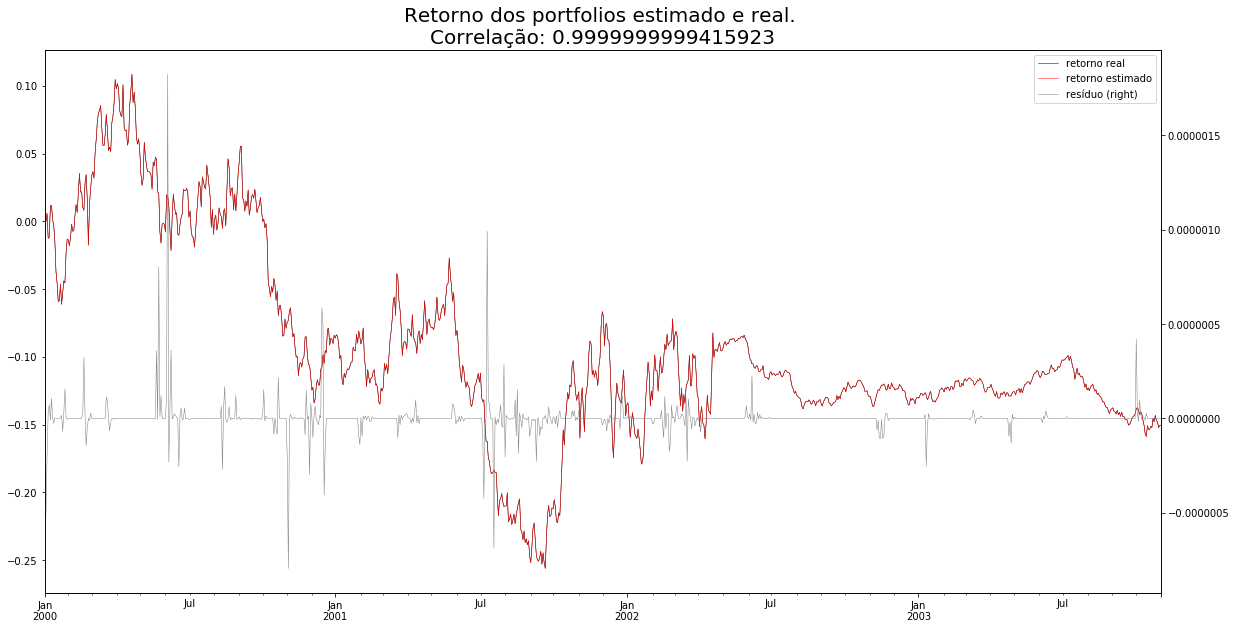

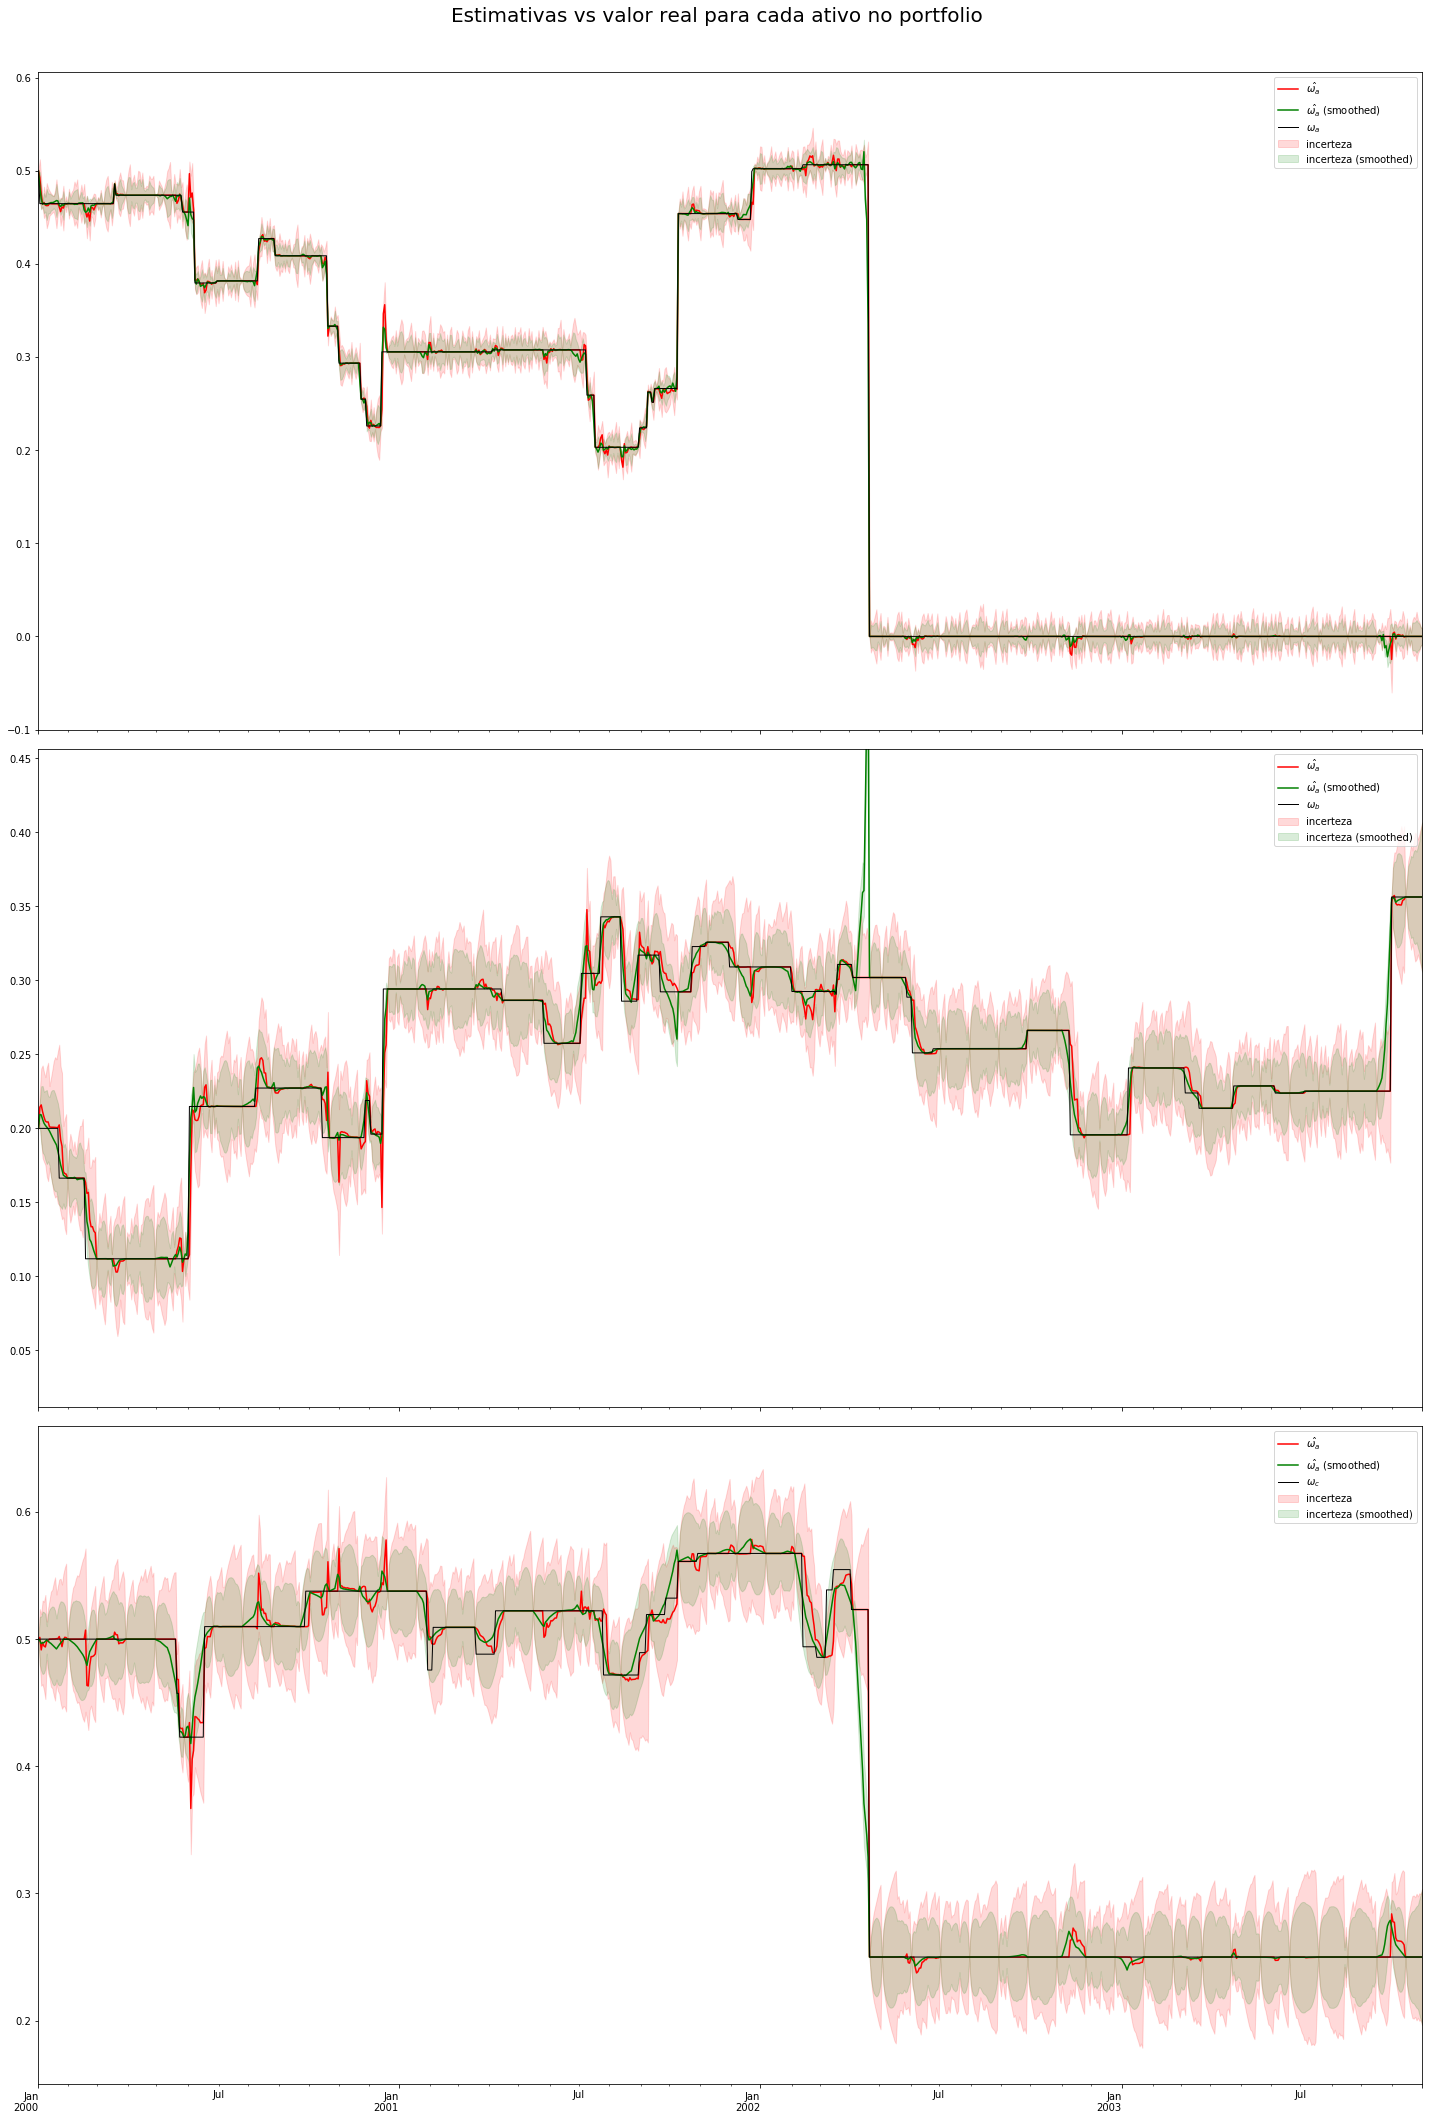

In [434]:
kf = KalmanFilter(3,4)

#State Transition Function F
kf.F = np.eye(3) * 1

#Process Noise Q
kf.Q *= 0.0005

#Initial Guess
kf.x = np.array([0.3, 0.3, 0.3])

#Measurement Noise R
kf.R *= 1e-10

#faz o loop para cada data
s = Saver(kf)
for i,dt in enumerate(stock.index):
    #Measurement Function H
    if ((i % 21) == 0) | ( i == 600):
        kf.H = np.vstack([stock.loc[dt].values.reshape(1,3), np.eye(3)])
    else:
        kf.H = np.zeros((4,3))
        kf.H[0] = stock.loc[dt].values.reshape(1,3)
    kf.predict() 
    kf.update(np.hstack([p1_return.loc[dt], p1.loc[dt]]))
    s.save()  
s.to_array()

## Calcula as matrizes smoothed
sx, sP, sK, spP = rts_smoother(s.x, s.P, s.F, s.Q)

retorno_estimado = pd.DataFrame(s.x, index=p1.index, columns=p1.columns).mul(stock).sum(axis=1)
#plota o retorno do portfolio estimado e os erros

ax = p1_return.cumsum().plot(figsize=(20,10), label="retorno real", color='black', lw=0.5, legend=True)
retorno_estimado.cumsum().plot(ax=ax, legend=True, color='red', label='retorno estimado', lw=0.5)
(p1_return - retorno_estimado).plot(secondary_y=True, color='gray', lw=0.5, label='resíduo', legend=True)
plt.title(f"Retorno dos portfolios estimado e real. \nCorrelação: {retorno_estimado.corr(p1_return)}", fontsize='20')

#Plota o grafico comparativo pra cada ativo
ax = pd.DataFrame(s.x, index=p1.index, columns=[r'$\hat{\omega_a}$',r'$\hat{\omega_a}$',r'$\hat{\omega_a}$' ]).plot(figsize=(20,30), color='red', linestyle='-', lw=1.5, subplots=True)
ax = pd.DataFrame(sx, index=p1.index, columns=[r'$\hat{\omega_a}$ (smoothed)',r'$\hat{\omega_a}$ (smoothed)',r'$\hat{\omega_a}$ (smoothed)' ]).plot(color='green', linestyle='-', lw=1.5, ax=ax, subplots=True)
ax = p1.rename(columns={k:"$\omega_"+k+"$" for k in p1}).plot(color='black', linestyle='-', lw=1, ax=ax, subplots=True)
[i.legend(fontsize='15') for i in ax]
for i,_ in enumerate(p1):
    ax[i].fill_between(p1.index.to_native_types(), (s.x[:,i] - np.sqrt(s.P[:,i,i])).astype(float), (s.x[:,i] + np.sqrt(s.P[:,i,i])).astype(float), alpha=0.15, color='red', label="incerteza")    
for i,_ in enumerate(p1):
    ax[i].fill_between(p1.index.to_native_types(), (sx[:,i] - np.sqrt(sP[:,i,i])).astype(float), (sx[:,i] + np.sqrt(sP[:,i,i])).astype(float), alpha=0.15, color='green', label='incerteza (smoothed)')
    ax[i].set_ylim(p1.iloc[:,i].min() - 0.1,p1.iloc[:,i].max()+ 0.1)
    ax[i].legend()

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.gcf().suptitle("Estimativas vs valor real para cada ativo no portfolio", fontsize="20");

